# Logistic Regresion with Is_male, Pclass, and 

## Finding well predicting models with different aspects of the features

The goal of stacked generalizations is to create a diverse set of models that predict in different fashions, then blend them together with a meta-learner. 

In my first iteration, I will create as many models as possible that predict with >0.75 accuracy. The goal will be to generate models that predict with different features so that there is not a large degree of correlation between the predictions. This will ensure the greatest chance for improvement in the final blended model.

Let's start:

## Logistic Regression

In [1]:
import os
os.chdir('C:\Users\Lundi\Documents\Programming\Python\Kaggle\Titanic - 2015\Stacked Generalization')
import metaLearning as meta

meta_learning = meta.metaLearning

In [48]:
os.chdir('C:\Users\Lundi\Documents\Programming\Python\Kaggle\Titanic - 2015')
#os.chdir('/Users/alexsutherland/Documents/Programming/Python/Kaggle/Titanic---2015')

import TitanicPreprocessor as tp
import TitanicPredictor as tpred
import sklearn.linear_model as skl_lm
import sklearn.grid_search as skl_gs
import sklearn.cross_validation as skl_cv
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

X, y, X_test, X_test_ids = tp.getData()

X_train, X_probe, y_train, y_probe = skl_cv.train_test_split(X, y, test_size=0.25, random_state = 0)

Creating the model

In [49]:
lr_clf = skl_lm.LogisticRegression()

lr_grid_params = [
    {'penalty': ['l1','l2'], 'C': np.logspace(-10,10,num=30)}
]

gs_lr_clf = skl_gs.GridSearchCV(lr_clf, param_grid=lr_grid_params, cv=10)

In [50]:
gs_lr_clf.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'C': array([  1.00000e-10,   4.89390e-10,   2.39503e-09,   1.17210e-08,
         5.73615e-08,   2.80722e-07,   1.37382e-06,   6.72336e-06,
         3.29034e-05,   1.61026e-04,   7.88046e-04,   3.85662e-03,
         1.88739e-02,   9.23671e-02,   4.52035e-01,   2....   3.56225e+06,   1.74333e+07,   8.53168e+07,   4.17532e+08,
         2.04336e+09,   1.00000e+10])}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [51]:
for params, mean_score, scores in gs_lr_clf.grid_scores_:
    print("%0.2f+/-%0.2f %r" % (mean_score, np.std(scores), params))

0.61+/-0.00 {'penalty': 'l1', 'C': 1e-10}
0.66+/-0.04 {'penalty': 'l2', 'C': 1e-10}
0.61+/-0.00 {'penalty': 'l1', 'C': 4.8939009184774994e-10}
0.66+/-0.04 {'penalty': 'l2', 'C': 4.8939009184774994e-10}
0.61+/-0.00 {'penalty': 'l1', 'C': 2.3950266199874909e-09}
0.66+/-0.04 {'penalty': 'l2', 'C': 2.3950266199874909e-09}
0.61+/-0.00 {'penalty': 'l1', 'C': 1.1721022975334793e-08}
0.66+/-0.04 {'penalty': 'l2', 'C': 1.1721022975334793e-08}
0.61+/-0.00 {'penalty': 'l1', 'C': 5.7361525104486813e-08}
0.66+/-0.04 {'penalty': 'l2', 'C': 5.7361525104486813e-08}
0.61+/-0.00 {'penalty': 'l1', 'C': 2.8072162039411812e-07}
0.65+/-0.04 {'penalty': 'l2', 'C': 2.8072162039411812e-07}
0.61+/-0.00 {'penalty': 'l1', 'C': 1.3738237958832638e-06}
0.65+/-0.04 {'penalty': 'l2', 'C': 1.3738237958832638e-06}
0.61+/-0.00 {'penalty': 'l1', 'C': 6.7233575364993352e-06}
0.65+/-0.03 {'penalty': 'l2', 'C': 6.7233575364993352e-06}
0.61+/-0.00 {'penalty': 'l1', 'C': 3.290344562312671e-05}
0.65+/-0.04 {'penalty': 'l2', 'C

### Feature weight vs. C value

In [52]:
lr_l1_coefs = []
cv_pred_accuracy = []

for current_C in np.logspace(-10,10,num=30):
    lr_clf = skl_lm.LogisticRegression(penalty='l1', C = current_C)
    lr_clf.fit(X_train, y_train)
    coef_list = lr_clf.coef_[0].tolist()
    coef_list.extend([current_C])
    lr_l1_coefs.append(lr_clf.coef_[0])
    cv_pred_accuracy.append(np.mean(skl_cv.cross_val_score(lr_clf, X_train, y_train, cv=10)))

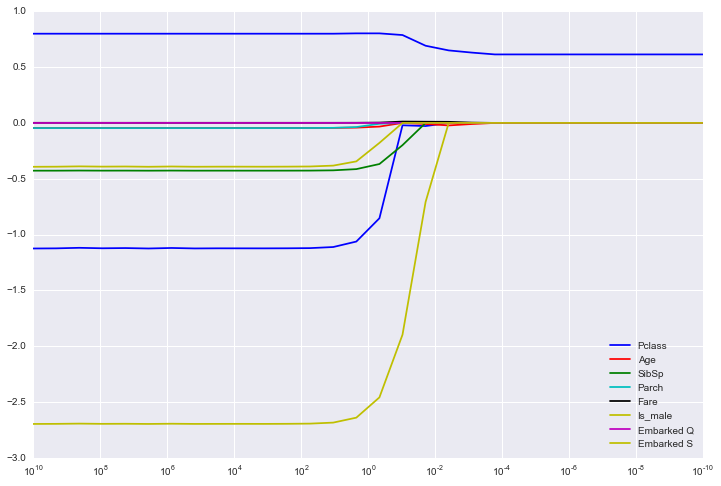

In [53]:
plt.rcParams['figure.figsize'] = 12,8
ax = plt.gca()
ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm','y'])

ax.plot(np.logspace(-10,10, num=30), lr_l1_coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.legend(X_train.columns, loc='lower right')
ax.plot(np.logspace(-10,10, num=30), cv_pred_accuracy)

Looking at this, I can see that the only features present at ~$C = 10^{-1}$ are Is_male, Pclass, and sibling. Let's generate a model with this three models only.

In [54]:
for params, mean_score, scores in gs_lr_clf.grid_scores_:
    print("%0.2f+/-%0.2f %r" % (mean_score, np.std(scores), params))

0.61+/-0.00 {'penalty': 'l1', 'C': 1e-10}
0.66+/-0.04 {'penalty': 'l2', 'C': 1e-10}
0.61+/-0.00 {'penalty': 'l1', 'C': 4.8939009184774994e-10}
0.66+/-0.04 {'penalty': 'l2', 'C': 4.8939009184774994e-10}
0.61+/-0.00 {'penalty': 'l1', 'C': 2.3950266199874909e-09}
0.66+/-0.04 {'penalty': 'l2', 'C': 2.3950266199874909e-09}
0.61+/-0.00 {'penalty': 'l1', 'C': 1.1721022975334793e-08}
0.66+/-0.04 {'penalty': 'l2', 'C': 1.1721022975334793e-08}
0.61+/-0.00 {'penalty': 'l1', 'C': 5.7361525104486813e-08}
0.66+/-0.04 {'penalty': 'l2', 'C': 5.7361525104486813e-08}
0.61+/-0.00 {'penalty': 'l1', 'C': 2.8072162039411812e-07}
0.65+/-0.04 {'penalty': 'l2', 'C': 2.8072162039411812e-07}
0.61+/-0.00 {'penalty': 'l1', 'C': 1.3738237958832638e-06}
0.65+/-0.04 {'penalty': 'l2', 'C': 1.3738237958832638e-06}
0.61+/-0.00 {'penalty': 'l1', 'C': 6.7233575364993352e-06}
0.65+/-0.03 {'penalty': 'l2', 'C': 6.7233575364993352e-06}
0.61+/-0.00 {'penalty': 'l1', 'C': 3.290344562312671e-05}
0.65+/-0.04 {'penalty': 'l2', 'C

This definitely shows that higher C (lower penalty improves the model). However, because I want some penalty, I will choose a model that has slightly less than 0.8 accuracy with a significant penalty:

In [55]:
lr_C_optimization_grid_params = [
    {'penalty': ['l1'], 'C': np.logspace(-2,-1,num=30)}
]

gs_lr_C_optimization_clf = skl_gs.GridSearchCV(lr_clf, param_grid=lr_C_optimization_grid_params, cv=10)
gs_lr_C_optimization_clf.fit(X_train, y_train)

for params, mean_score, scores in gs_lr_C_optimization_clf.grid_scores_:
    print("%0.2f+/-%0.2f %r" % (mean_score, np.std(scores), params))

0.65+/-0.04 {'penalty': 'l1', 'C': 0.01}
0.65+/-0.04 {'penalty': 'l1', 'C': 0.010826367338740546}
0.65+/-0.04 {'penalty': 'l1', 'C': 0.0117210229753348}
0.65+/-0.04 {'penalty': 'l1', 'C': 0.01268961003167922}
0.65+/-0.03 {'penalty': 'l1', 'C': 0.01373823795883263}
0.66+/-0.04 {'penalty': 'l1', 'C': 0.014873521072935119}
0.67+/-0.04 {'penalty': 'l1', 'C': 0.016102620275609391}
0.68+/-0.03 {'penalty': 'l1', 'C': 0.017433288221999882}
0.69+/-0.03 {'penalty': 'l1', 'C': 0.018873918221350976}
0.69+/-0.02 {'penalty': 'l1', 'C': 0.020433597178569417}
0.71+/-0.04 {'penalty': 'l1', 'C': 0.022122162910704492}
0.73+/-0.04 {'penalty': 'l1', 'C': 0.023950266199874861}
0.73+/-0.04 {'penalty': 'l1', 'C': 0.025929437974046669}
0.74+/-0.03 {'penalty': 'l1', 'C': 0.02807216203941177}
0.76+/-0.04 {'penalty': 'l1', 'C': 0.030391953823131979}
0.78+/-0.05 {'penalty': 'l1', 'C': 0.032903445623126679}
0.78+/-0.04 {'penalty': 'l1', 'C': 0.035622478902624426}
0.79+/-0.04 {'penalty': 'l1', 'C': 0.038566204211634

In [60]:
lr_clf = skl_lm.LogisticRegression(penalty='l1', C=0.04)
lr_clf.fit(X_train, y_train)

lr_cv_scores = skl_cv.cross_val_score(lr_clf, X_train, y_train, cv=10)
print ("Optimized Log Reg. Mean (training CV): %0.2f+/-%0.2f" % (np.mean(lr_cv_scores), np.std(lr_cv_scores)))


Optimized Log Reg. Mean (training CV): 0.79+/-0.04


## Predicting probe with optimized Logistic Regression Model 

In [67]:
lr_clf = skl_lm.LogisticRegression(penalty='l1', C=0.04)

lr_clf.fit(X_train, y_train)

y_probe_pred = lr_clf.predict(X_probe)
y_probe_pred_probs = lr_clf.predict_proba(X_probe)

y_pred_prob_survived = pd.DataFrame(pd.DataFrame(y_probe_pred_probs)[1])
y_pred_prob_survived['id'] = X_probe.index
y_pred_prob_survived.columns = ['lr_prob_survival','id']
y_pred_prob_survived.to_csv('Stacked Generalization/Data/log_reg_probe_pred.csv', index=False)

## Predicting test set with Log Regr Model:

In [66]:
lr_clf = skl_lm.LogisticRegression(penalty='l1', C=0.04)

lr_clf.fit(X, y)
y_pred = lr_clf.predict(X_test)
y_pred_probs = lr_clf.predict_proba(X_test)

y_pred_prob_survived = pd.DataFrame(pd.DataFrame(y_pred_probs)[1])
y_pred_prob_survived['test_id'] = X_test_ids
y_pred_prob_survived.columns = ['lr_perc_survival','test_id']
y_pred_prob_survived.to_csv('Stacked Generalization/Data/log_reg_test_pred.csv', index=False)